as in https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano
import warnings
from numpy.random import binomial, randn, uniform
from sklearn.model_selection import train_test_split


In [2]:
%matplotlib inline

sns.set()
warnings.filterwarnings('ignore')


In [3]:
alpha_0 = 1
alpha_1 = 1.25

beta_0 = 1
beta_1 = 1.25

sigma = 0.75


,y,x,category
0,2.396902,2.128428,0
1,4.507059,3.973046,1
2,5.411640,4.756704,0
3,9.816339,8.349644,0
4,7.034314,5.010763,1


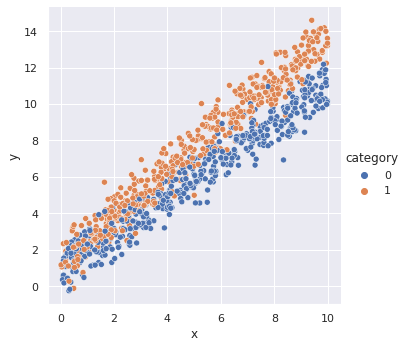

In [4]:
n_samples = 1000

category = binomial(n=1, p=0.5, size=n_samples)
x = uniform(low=0, high=10, size=n_samples)

y = ((1 - category) * alpha_0 + category * alpha_1
     + ((1 - category) * beta_0 + category * beta_1) * x
     + sigma * randn(n_samples))

model_data = pd.DataFrame({'y': y, 'x': x, 'category': category})

display(model_data.head())
_ = sns.relplot(x='x', y='y', hue='category', data=model_data)


In [5]:
train, test = train_test_split(
    model_data, test_size=0.2, stratify=model_data.category)


In [6]:
y_tensor = theano.shared(train.y.values.astype('float64'))
x_tensor = theano.shared(train.x.values.astype('float64'))
cat_tensor = theano.shared(train.category.values.astype('int64'))


In [7]:
with pm.Model() as model:
    alpha_prior = pm.HalfNormal('alpha', sd=2, shape=2)
    beta_prior = pm.Normal('beta', mu=0, sd=2, shape=2)
    sigma_prior = pm.HalfNormal('sigma', sd=2, shape=1)
    mu_likelihood = alpha_prior[cat_tensor] + beta_prior[cat_tensor] * x_tensor
    y_likelihood = pm.Normal('y', mu=mu_likelihood, sd=sigma_prior, observed=y_tensor)


In [8]:
with model:
    hmc_trace = pm.sample(draws=5000, tune=1000, cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 8 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.998,0.013,0.974,1.021,0.000,0.000,5752.0,5949.0,1.0
beta[1],1.245,0.013,1.220,1.269,0.000,0.000,5818.0,6090.0,1.0
alpha[0],1.026,0.073,0.897,1.168,0.001,0.001,5833.0,6016.0,1.0
alpha[1],1.275,0.077,1.131,1.418,0.001,0.001,5703.0,5417.0,1.0
sigma[0],0.741,0.019,0.706,0.778,0.000,0.000,7471.0,6168.0,1.0


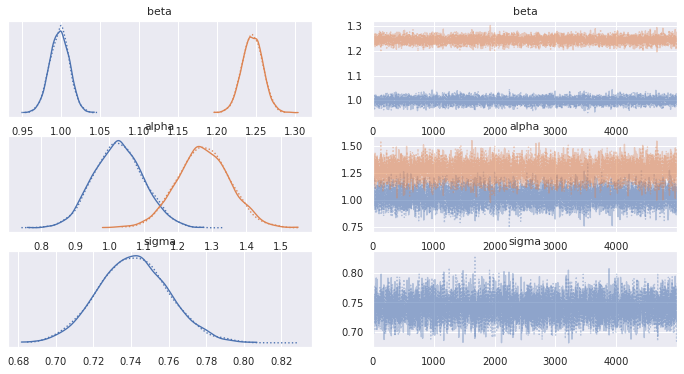

In [9]:
pm.traceplot(hmc_trace)
pm.summary(hmc_trace)
